For benchmarking exact search methods

(1) Brute Force (2) Held–Karp algorithm (3) Linear Programming

In [5]:
import csv
import time
import pulp
import itertools
import numpy as np
from scipy.spatial import distance_matrix

def get_dist_kaggle(file_path):
    coordinates = []
    with open(file_path, newline='', encoding='utf-8') as csvfile:
        reader = csv.reader(csvfile)
        for row in reader:
            coordinates.append([float(row[0]), float(row[1])])
    coordinates = np.array(coordinates)
    dist_matrix = distance_matrix(coordinates, coordinates)
    return dist_matrix

def get_dist_tsplib(file_path):
    coordinates = []
    with open(file_path, newline='', encoding='utf-8') as csvfile:
        reader = csv.reader(csvfile)
        inside_coords = False
        for row in reader:
            if row and row[0] == 'NODE_COORD_SECTION':  # Start reading coordinates
                inside_coords = True
                continue
            if row and row[0] == 'EOF':  # End of coordinates section
                inside_coords = False
                continue

            if inside_coords:
                # Extract coordinates (ignore the city number)
                x, y = row[0].split(" ")[1], row[0].split(" ")[2]
                coordinates.append((float(x), float(y)))
    dist_matrix = distance_matrix(coordinates, coordinates)
    return dist_matrix

def BruteForce(dist_matrix):
    n = len(dist_matrix)
    best_permutation = []
    min_distance = 10000000
    all_permutation = list(itertools.permutations(range(1, n)))
    for i in range(len(all_permutation)):
        route = list(all_permutation[i])
        route.insert(0, 0)
        route.append(0)
        total_distance = 0
        for j in range(len(route)-1):
            total_distance = total_distance + dist_matrix[route[j],route[j+1]]
        if total_distance < min_distance:
            min_distance = total_distance
            best_permutation = route
    return min_distance, best_permutation

def held_karp(dists):

    n = len(dists)

    # Maps each subset of the nodes to the cost to reach that subset, as well
    # as what node it passed before reaching this subset.
    # Node subsets are represented as set bits.
    C = {}

    # Set transition cost from initial state
    for k in range(1, n):
        C[(1 << k, k)] = (dists[0][k], 0)

    # Iterate subsets of increasing length and store intermediate results
    # in classic dynamic programming manner
    for subset_size in range(2, n):
        for subset in itertools.combinations(range(1, n), subset_size):
            # Set bits for all nodes in this subset
            bits = 0
            for bit in subset:
                bits |= 1 << bit

            # Find the lowest cost to get to this subset
            for k in subset:
                prev = bits & ~(1 << k)

                res = []
                for m in subset:
                    if m == 0 or m == k:
                        continue
                    res.append((C[(prev, m)][0] + dists[m][k], m))
                C[(bits, k)] = min(res)

    # We're interested in all bits but the least significant (the start state)
    bits = (2**n - 1) - 1

    # Calculate optimal cost
    res = []
    for k in range(1, n):
        res.append((C[(bits, k)][0] + dists[k][0], k))
    opt, parent = min(res)

    # Backtrack to find full path
    path = [0]
    for i in range(n - 1):
        path.append(parent)
        new_bits = bits & ~(1 << parent)
        _, parent = C[(bits, parent)]
        bits = new_bits

    # Add implicit start state
    path.append(0)

    return opt, list(reversed(path))

def LinearProgramming(dist_matrix):

    n = len(dist_matrix)

    # Define the ILP problem
    problem = pulp.LpProblem("TSP", pulp.LpMinimize)

    # Decision variables: x[i][j] is 1 if the route from city i to j is used
    x = pulp.LpVariable.dicts('x', (range(n), range(n)), cat='Binary')

    # MTZ variables: u[i] helps to eliminate subtours (only needed for cities 1 to n-1)
    u = pulp.LpVariable.dicts('u', range(n), lowBound=0, upBound=n, cat='Continuous')

    # Objective function: minimize total travel distance
    problem += pulp.lpSum(dist_matrix[i][j] * x[i][j] for i in range(n) for j in range(n)), "TotalDistance"

    # Degree constraints: each city leaves and enters exactly once
    for i in range(n):
        problem += pulp.lpSum(x[i][j] for j in range(n) if j != i) == 1, f"Out_{i}"
        problem += pulp.lpSum(x[j][i] for j in range(n) if j != i) == 1, f"In_{i}"

    # MTZ Subtour elimination constraints (for cities 1 to n-1)
    for i in range(1, n):
        for j in range(1, n):
            if i != j:
                problem += u[i] - u[j] + n * x[i][j] <= n - 1, f"MTZ_{i}_{j}"

    # Solve the problem using PuLP's default solver (CBC)
    problem.solve(pulp.PULP_CBC_CMD(msg=0))

    solution_edges = [(i, j) for i in range(n) for j in range(n) if pulp.value(x[i][j]) == 1]

    next_city = {}
    for (i, j) in solution_edges:
        next_city[i] = j

    tour = [0]
    current = 0
    while True:
        current = next_city[current]
        tour.append(current)
        if current == 0:
            break

    opt = sum(dist_matrix[i, j] for i in range(n) for j in range(n) if pulp.value(x[i][j]) == 1)

    return opt, list(reversed(tour))

In [6]:
file_path = '../dataset/Github/tiny.csv'
dist_matrix = get_dist_kaggle(file_path)
time1 = time.time()
opt1, path1 = held_karp(dist_matrix)
time2 = time.time()
opt2, path2 = BruteForce(dist_matrix)
time3 = time.time()
opt3, path3 = LinearProgramming(dist_matrix)
time4 = time.time()
print("=========== Result ==========")
print("Number of cities:", len(dist_matrix))
print("Time used for Held Karp algorithm: ", time4-time3)
print("Route and cost of Held Karp algorithm: ", path1, opt1)
print("Time used for Brute Force algorithm: ", time3-time2)
print("Route and cost of Brute Force algorithm: ", path2, opt2)
print("Time used for Linear Programming algorithm: ", time2-time1)
print("Route and cost of Linear Programming algorithm: ", path3, opt3)

=========== Result ==========
Number of cities: 10
Time used for Held Karp algorithm:  0.11384773254394531
Route and cost of Held Karp algorithm:  [0, 4, 1, 5, 8, 2, 7, 6, 9, 3, 0] 12.516978039789695
Time used for Brute Force algorithm:  0.8836855888366699
Route and cost of Brute Force algorithm:  [0, 4, 1, 5, 8, 2, 7, 6, 9, 3, 0] 12.516978039789695
Time used for Linear Programming algorithm:  0.0
Route and cost of Linear Programming algorithm:  [0, 4, 1, 5, 8, 2, 7, 6, 9, 3, 0] 12.516978039789695


In [7]:
import random

def get_dist_kaggle_ncities(file_path, n):
    coordinates = []
    with open(file_path, newline='', encoding='utf-8') as csvfile:
        reader = csv.reader(csvfile)
        for row in reader:
            coordinates.append([float(row[0]), float(row[1])])
    coordinates = np.array(coordinates)

    # randomly choose n cities
    random.seed(42)
    indices = random.sample(range(len(coordinates)), n)
    selected_coords = coordinates[indices]

    dist_matrix = distance_matrix(selected_coords, selected_coords)
    return dist_matrix


file_path = '../dataset/Github/small.csv'
n_list = range(4, 13)
held_karp_list = []
BruteForce_list = []
LinearProgramming_list = []
for n in n_list:
    dist_matrix = get_dist_kaggle_ncities(file_path, n)
    time1 = time.time()
    opt1, path1 = held_karp(dist_matrix)
    time2 = time.time()
    opt2, path2 = BruteForce(dist_matrix)
    time3 = time.time()
    opt3, path3 = LinearProgramming(dist_matrix)
    time4 = time.time()
    held_karp_list.append(time2-time1)
    BruteForce_list.append(time3-time2)
    LinearProgramming_list.append(time4-time3)
    print('Finish running ', n)


Finish running  4
Finish running  5
Finish running  6
Finish running  7
Finish running  8
Finish running  9
Finish running  10
Finish running  11
Finish running  12


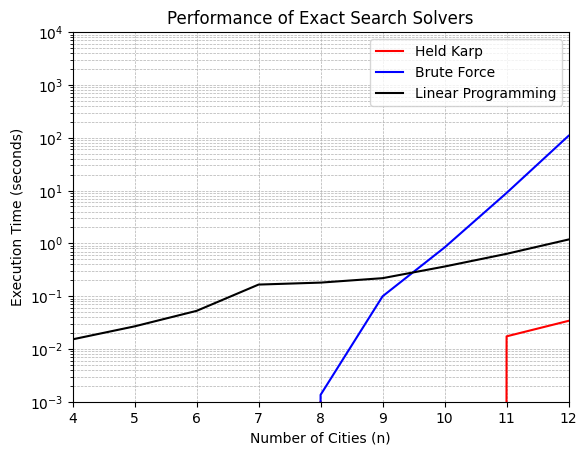

In [8]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(n_list, held_karp_list, '-', color='red', label='Held Karp')
plt.plot(n_list, BruteForce_list , '-', color='blue', label='Brute Force')
plt.plot(n_list, LinearProgramming_list, '-', color='black', label='Linear Programming')

plt.title("Performance of Exact Search Solvers")
plt.xlabel("Number of Cities (n)")
plt.ylabel("Execution Time (seconds)")
plt.yscale("log")

plt.xlim(min(n_list), max(n_list))
plt.ylim(1e-3, 1e4)  

ax = plt.gca()
ax.yaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=10))
ax.yaxis.set_minor_locator(ticker.LogLocator(base=10.0, subs='auto', numticks=10))
ax.yaxis.set_minor_formatter(ticker.NullFormatter())  
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.legend()
plt.show()

